In [1]:
import metalearning_benchmarks.line_sine1d_benchmark
import torch
import wandb
from matplotlib import pyplot as plt
from metalearning_benchmarks.line_sine1d_benchmark import LineSine1D
from neural_process import NeuralProcess
from np_train_val import train_and_validate
from utils import (Config, DataConfig, DataModule, MetaLearningDataset,
                   ModelConfig, TrainValConfig, split_context_target)
from visualize import visualize_batch_1d

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
data_config = DataConfig(
    benchmark="LineSine1D",
    n_task=4096,
    n_datapoints_per_task=64,
    output_noise=0.1,
    seed_task=1237, 
    seed_x=123, 
    seed_noise=1237
)

model_config = ModelConfig(
    x_dim=1,
    y_dim=1,
    r_dim=16,
    z_dim=2,
    h_dim=64,
    num_layers_det_enc=6,
    num_layers_lat_enc=6,
    num_layers_dec=6,
    non_linearity="SiLU",
    is_attentive=True,
    has_parallel_paths=False
)

train_val_config = TrainValConfig(
    batch_size=128,
    num_epochs=400,
    learning_rate=3e-4,
    split=(0.8, 0.2)
)

config = Config(
    data_config=data_config,
    model_config=model_config,
    train_val_config=train_val_config
)

In [4]:
benchmark = getattr(metalearning_benchmarks.line_sine1d_benchmark, config.data_config.benchmark)(
    n_task=config.data_config.n_task,
    n_datapoints_per_task=config.data_config.n_datapoints_per_task,
    output_noise=config.data_config.output_noise,
    seed_task=config.data_config.seed_task, 
    seed_x=config.data_config.seed_x, 
    seed_noise=config.data_config.seed_noise,
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=config.train_val_config.batch_size,
    dataset_and_split=(dataset, config.train_val_config.split),
    num_workers=15
)

Generating tasks:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 259381.42it/s]


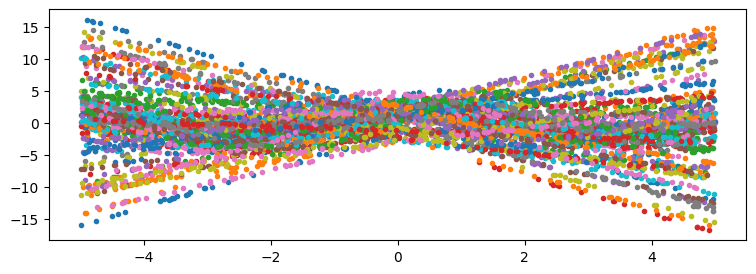

In [5]:
visualize_batch_1d(batch=next(iter(data_module.train_dataloader())))

In [6]:
model = NeuralProcess(**config.model_config.asdict()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.train_val_config.learning_rate)

In [7]:
wandb_logging = True
if wandb_logging:
    wandb.init(project="diffu-vi-np", config=config.asdict())

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [8]:
avg_train_neg_log_likes = []
avg_train_kl_divs = []

avg_val_neg_log_likes = []
avg_val_kl_divs = []

In [9]:
losses = train_and_validate(
    model=model,
    data_module=data_module,
    num_epochs=config.train_val_config.num_epochs,
    device=device,
    optimizer=optimizer,
    wandb_logging=wandb_logging,
)

avg_train_neg_log_likes.extend(losses[0])
avg_train_kl_divs.extend(losses[1])

avg_val_neg_log_likes.extend(losses[2])
avg_val_kl_divs.extend(losses[3])

  0%|          | 0/26 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
100%|██████████| 7/7 [00:00<00:00, 13.04it/s, epoch=399, kl_div=3.53, loss=71.5, recon_loss=68]  


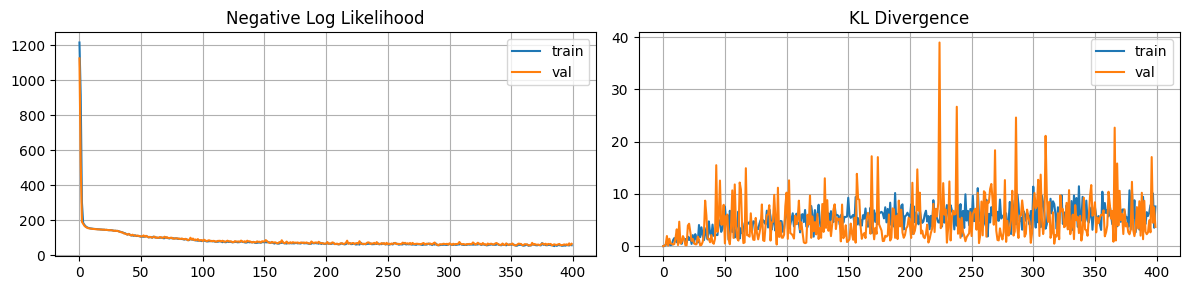

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(avg_train_neg_log_likes, label="train")
ax[0].plot(avg_val_neg_log_likes, label="val")
ax[0].set_title("Negative Log Likelihood")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_kl_divs, label="train")
ax[1].plot(avg_val_kl_divs, label="val")
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

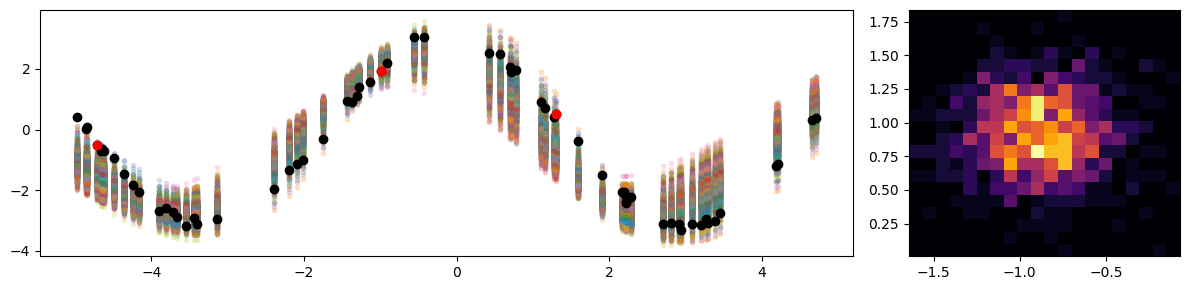

In [33]:
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)
x_data, y_data = next(iter(gen_dataloader))
x_data, y_data = x_data.to(device), y_data.to(device)

context_len = 3 # x_data.shape[1] - 1
x_context, y_context, _, _ = split_context_target(x_data, y_data, context_len=context_len, random=False)

n_samples = 1024

model.eval()
_, y_mu, _, z, _, _ = model.sample(x_context, y_context, x_data, n_samples)

x_data = x_data.cpu().detach().numpy()
y_data = y_data.cpu().detach().numpy()
x_context = x_context.cpu().detach().numpy()
y_context = y_context.cpu().detach().numpy()
y_mu = y_mu.cpu().detach().numpy()
z = z.cpu().detach().numpy()

_, ax  = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'width_ratios': [3, 1]})

for i in range(n_samples):
    ax[0].scatter(x_data, y_mu[i], marker=".", alpha=0.2)

ax[0].scatter(x_data, y_data, marker="o", c="black")
ax[0].scatter(x_context, y_context, marker="o", c="red")

ax[1].hist2d(z[:, 0, 0], z[:, 0, 1], bins=20, cmap="inferno")

plt.tight_layout()
plt.show()

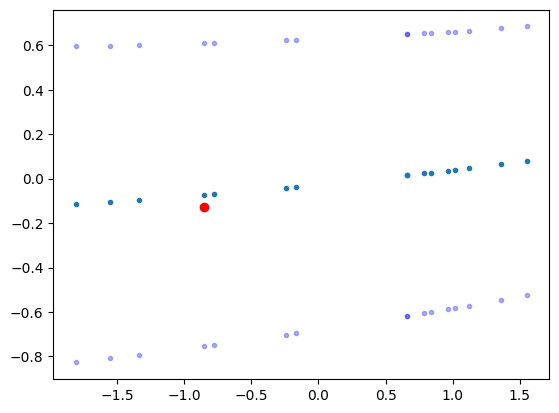

In [30]:
# model.load_state_dict(torch.load("../../models/icy-salad-8.pt"))
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)

x_data, y_data = next(iter(gen_dataloader))
x_data, y_data = x_data.to(device), y_data.to(device)

context_len = 1
x_context, y_context, x_target, y_target = split_context_target(x_data, y_data, context_len=context_len, random=True)

n_samples = 1

model.eval()
y, y_mu, y_std = model(x_context, y_context, x_data)

plt.figure(figsize=(9, 3))

for i in range(n_samples):
    plt.scatter(x_data.cpu().detach().numpy(), y_mu[i].cpu().detach().numpy(), marker=".")
    plt.scatter(
        x_data.cpu().detach().numpy(), 
        (y_mu[i] - 2 * y_std).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )
    plt.scatter(
        x_data.cpu().detach().numpy(), 
        (y_mu[i] + 2 * y_std).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )

plt.scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="o", c="red")

plt.show()

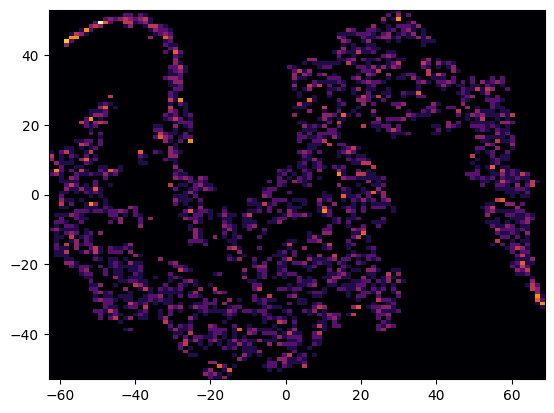

In [105]:
import numpy as np
from sklearn.manifold import TSNE

X = np.array([m[0] for m in mus])
X_embedded = TSNE(n_components=2).fit_transform(X)

plt.hist2d(X_embedded[:, 0], X_embedded[:, 1], bins=100, cmap="inferno")
plt.show()